In [1]:
# load necessary libraries
import numpy as np
from scipy import ndimage
from scipy import misc
from scipy import stats
from scipy.ndimage.filters import gaussian_filter as gf

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle as Rec

from skimage import filters
from skimage import transform as tf

import csv
import json
import random
import urllib
from PIL import Image

import sys, os
import pandas as pd
import pickle
from datetime import datetime
import glob

from projEdgeBreaks import *
from imageModifiers import *
from saveImages import *
from plottingFuncs import *

# change pandas parameter
pd.options.mode.chained_assignment = None
# change plot size
mpl.rcParams["figure.figsize"] = (15, 15)

In [2]:
clExp = pd.read_csv("data/letter-slope-classifications_10nov2017.csv")
clExp = clExp.loc[clExp["workflow_version"] == 16.28]
# len(clExp.loc[:,"subject_ids"].drop_duplicates())
# len(clExp.loc)
clExp["subj_json"] = [json.loads(q) for q in clExp["subject_data"]]
clExp["hdl_id"] = [q.get(list(q.keys())[0]).get("hdl_id", "") for q in clExp["subj_json"]]
clExp = clExp.loc[clExp["hdl_id"] != ""]

In [3]:
consensusFolder = "C:/Users/danny/Repos/text_segmentation/consensus/consensus/"
# consensusFile = consensusFolder + "decoding-the-civil-war-consensus-linewise_{mss_label}.csv"
subjFile = "data/decoding-the-civil-war-subjects-9-29-17.csv"
savefile = "accuracy.pkl"

consensusCsvFiles = glob.glob(
    '{}/*.csv'.format(consensusFolder))
consensusCsvFiles = [i for i in consensusCsvFiles if "linewise" in i]

In [11]:
subj = pd.read_csv(subjFile)
# get only the workflow from the live project
subj = subj.loc[subj['workflow_id'] == 1874]

# get metadata in dictionary format
subj["meta_json"] = [json.loads(q) for q in subj["metadata"]]
# get hdl_id from metadata
subj["hdl_id"] = [q.get("hdl_id", "mssF") for q in subj["meta_json"]]
# get image url
subj["url"] = [json.loads(q).get("0") for q in subj["locations"]]

# remove images without ids
subj = subj[subj["hdl_id"] != "mssF"]
# remove codebook images (mssEC_36-67)
filt = subj["hdl_id"].str.contains("mssEC_3[6-9]|[4-6][0-9]")
subj = subj[~filt]
# remove ledgers that seemed weird (only easy stuff for now)
filt = subj["hdl_id"].str.contains("mssEC_3[0-3]|2[6-9]")
subj = subj[~filt]
# remove the first few pages because they tended to be blank
filt = subj["hdl_id"].str.contains("mssEC_\d\d_00[1-6]")
subj = subj[~filt]

In [5]:
with open("accuracy_old.pkl", "rb") as f:
    data = pickle.load(f)

In [49]:
hdl_id = "mssEC_22_170"
there = np.where(subj["hdl_id"] == hdl_id)[0][0]
url = subj.iloc[there]["url"]
thisn = data[hdl_id]
segments = thisn["segment"]
let, grey = readImg(url)

nuOpt = np.arange(0.5, 6.5, 0.5) # 0.5:6.5
biOpt = list(range(1, 10)) # 1:10

In [81]:
# get best one
most = np.inf
mind = (0,0)
for nu in nuOpt:
    for bi in biOpt:
        bi2 = list(segments['bi'] == bi)
        nu2 = list(segments['nu'] == nu)
        getm = [bi2[i] and nu2[i] for i in range(len(segments))]
        tmp = segments.loc[getm]
        wrong = np.sum(len(tmp['br'])-1 != tmp['nr']) * 1.0/ len(tmp)
        print(wrong, end = " ")
        if wrong < most:
            most = wrong
            mind = (nu, bi)

1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 

In [86]:
list(tmp['br'])

[array([   0,  746, 1375]),
 array([   0,  745, 1384]),
 array([   0,  260,  493,  656,  803, 1001, 1228, 1415]),
 array([  14,  219,  574,  942, 1216, 1440]),
 array([  16,  358,  665,  842,  988, 1151, 1307, 1430]),
 array([  42,  369,  657,  861,  996, 1163, 1310, 1435]),
 array([   9,  290,  548,  698,  921, 1222, 1434]),
 array([  70,  762, 1438]),
 array([  70,  755, 1432]),
 array([  63,  759, 1429]),
 array([   0,  818, 1434]),
 array([   0,  751, 1425]),
 array([   0,  763, 1433]),
 array([  70,  757, 1435]),
 array([   0,  754, 1420]),
 array([   0,  759, 1418]),
 array([   0,  191,  376,  691, 1144, 1420]),
 array([   0,  760, 1423]),
 array([   0,  757, 1430]),
 array([  15,   61,  215,  335,  513,  772, 1042, 1220, 1440])]

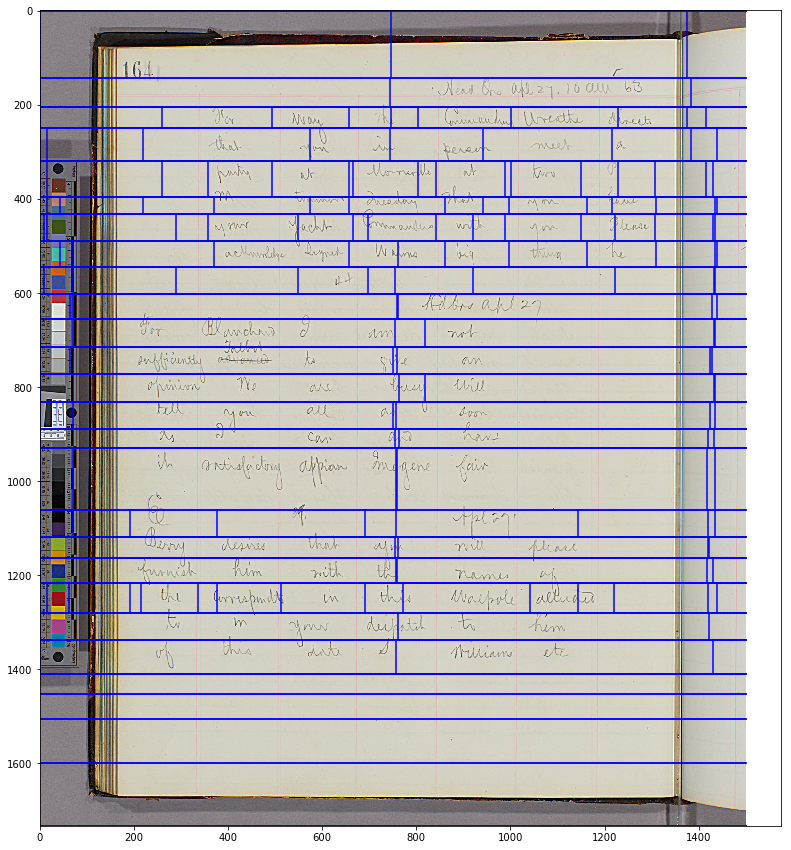

In [92]:
plotBoxes(let, thisn['lb'][list(tmp['i'])], list(tmp['br']))

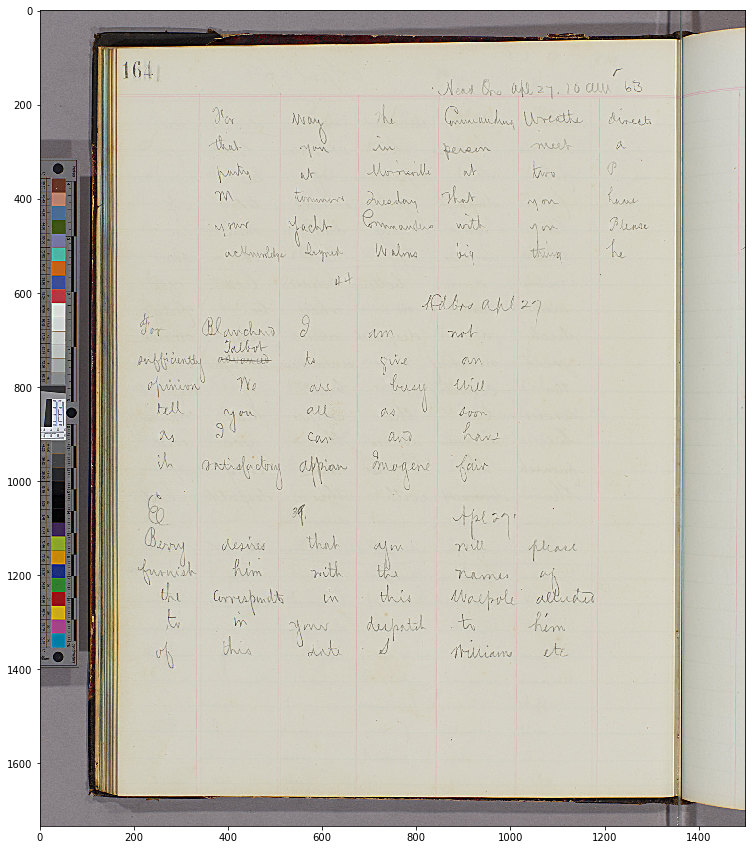

In [93]:
plt.imshow(let)
plt.show()